## Move Reviews Sentiment Analysis##
**sklearn modeling**

In [33]:
#Basic imports
import pandas as pd
import numpy as np
import os
import warnings
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
warnings.filterwarnings('ignore')

#Plotting Imports (interactive)
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

#Preprocessing Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modeling Imports
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Loading Data

In [34]:
data_path = '/Users/IlanaWeinstein/Desktop/Cadent/sentiment-analysis-on-movie-reviews'
train = pd.DataFrame(pd.read_csv(data_path + '/' + 'train.tsv', sep='\t'))
test = pd.DataFrame(pd.read_csv(data_path + '/' + 'test.tsv', sep='\t'))

In [35]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [36]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [39]:
X_train = train.drop(['Sentiment'], axis=1)
y_train = train['Sentiment']

X_test = test

In [40]:
X_train = X_train.replace(np.nan, " ")
X_test = X_test.replace(np.nan, " ")

In [41]:
train_texts, train_labels = X_train['Phrase'], y_train
val_texts = X_test['Phrase']

### Prelimary Analysis (Interactive)

In [37]:
#Showing the distribution of labels for the first 6 sentences. 
def color():
    output = "rgb{}".format(tuple(np.random.choice(range(256), size=3)))
    return output

y0 = train[train['SentenceId'] == 1]['Sentiment']
y1 = train[train['SentenceId'] == 2]['Sentiment']
y2 = train[train['SentenceId'] == 3]['Sentiment']
y3 = train[train['SentenceId'] == 4]['Sentiment']
y4 = train[train['SentenceId'] == 5]['Sentiment']
y5 = train[train['SentenceId'] == 6]['Sentiment']

trace0 = go.Box(y=y0,name = 'Sentence 1',marker = dict(color = color(),))
trace1 = go.Box(y=y1,name = 'Sentence 2',marker = dict(color = color(),))
trace2 = go.Box(y=y2,name = 'Sentence 3',marker = dict(color = color(),))
trace3 = go.Box(y=y3,name = 'Sentence 4',marker = dict(color = color(),))
trace4 = go.Box(y=y4,name = 'Sentence 5',marker = dict(color = color(),))
trace5 = go.Box(y=y5,name = 'Sentence 6',marker = dict(color = color(),))

data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(title = "Sentiment Polarity Boxplot of Sentence Phrases (SentenceID)")

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Sentence Phrases (SentenceID)")

In [121]:
#Data imbalance
fig = plt.figure(figsize=(2,1.5))
train.groupby('Sentiment').Phrase.count().iplot(kind='bar', yTitle='Count',
                                                linecolor='black', title='Sentiment Label Distribution')

<Figure size 144x108 with 0 Axes>

Data is imbalanced, going to use F1 score to compare models but will also look at accuracy score as that is Kaggle's metric of choice. The classification polarity for phrases make me believe that this is a more complicated sentiment classification problem.

In [122]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(X_train['Phrase'], 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

In [123]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(X_train['Phrase'], 20)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [124]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(X_train['Phrase'], 20)

df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')

In [125]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(X_train['Phrase'], 20)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')


### Vectorization/Feature Selection

In [46]:
binary_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english',max_features = 2000)

In [47]:
binary_vectorizer.fit(X_train['Phrase'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [48]:
#Output is sparse matrix
X_train_binary = binary_vectorizer.transform(X_train['Phrase'])
X_test_binary = binary_vectorizer.transform(X_test['Phrase'])

In [49]:
#TfidfVectorizer
binary_Tfidf_vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2), stop_words='english',max_features = 2000)
binary_Tfidf_vectorizer.fit(X_train['Phrase'])

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=2000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [50]:
#Output is sparse matrix
X_train_binary_Tfidf = binary_Tfidf_vectorizer.transform(X_train['Phrase'])
X_test_binary_Tfidf = binary_Tfidf_vectorizer.transform(X_test['Phrase'])

## Model Selection ##

    -Cross Validation: KNN, RF, LinearSVC, MultinomialNB, LogReg, Perceptron
        -Count Vecotrizer and Tfidf
    -Grid Search: Linear SVC, LogReg

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 

def CrossVal(X_train,y_train, CV = 5):
    
    models = [
        KNeighborsClassifier(n_neighbors=3),
        RandomForestClassifier(random_state = 0),
        LinearSVC(random_state = 0),
        MultinomialNB(),
        LogisticRegression(random_state=0, multi_class = 'ovr'),
        Perceptron(random_state = 0),
    ]
    
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    outputs = []
    
    for model in tqdm(models):
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=CV)
        for fold_idx, accuracy in tqdm(enumerate(accuracies)):
            outputs.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(outputs, columns=['model_name', 'fold_idx', 'accuracy'])

    import seaborn as sns
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    sns.set(rc={'figure.figsize':(20,10)})
    
    plt.show()
    
    return cv_df


  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

5it [00:00, 544.21it/s]
 17%|█▋        | 1/6 [07:59<39:56, 479.30s/it]

0it [00:00, ?it/s]

5it [00:00, 974.83it/s]
 33%|███▎      | 2/6 [1:06:18<1:32:20, 1385.15s/it]

0it [00:00, ?it/s]

5it [00:00, 967.90it/s]
 50%|█████     | 3/6 [1:13:05<54:35, 1091.90s/it]  

0it [00:00, ?it/s]

5it [00:00, 468.50it/s]
 67%|██████▋   | 4/6 [1:13:06<25:28, 764.46s/it] 

0it [00:00, ?it/s]

5it [00:00, 557.18it/s]
 83%|████████▎ | 5/6 [1:13:50<09:08, 548.55s/it]

0it [00:00, ?it/s]

5it [00:00, 1179.77it/s]
100%|██████████| 6/6 [1:13:55<00:00, 385.39s/it]

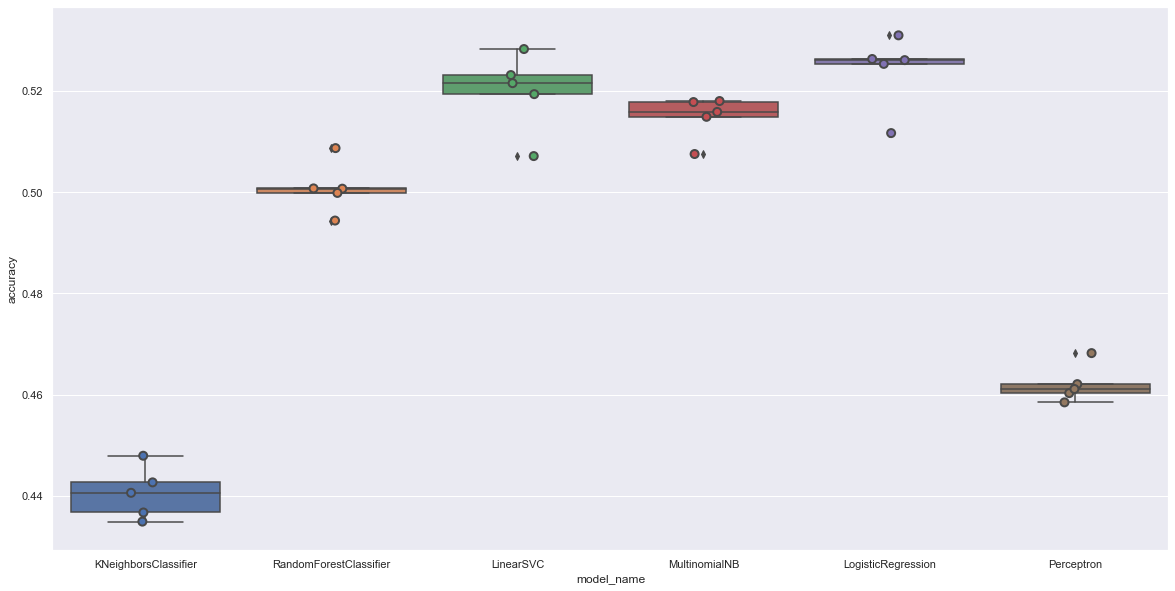

In [103]:
df_countv = CrossVal(X_train_binary,y_train)



  0%|          | 0/6 [00:00<?, ?it/s]


0it [00:00, ?it/s]


5it [00:00, 710.92it/s]

 17%|█▋        | 1/6 [08:32<42:44, 512.98s/it]


0it [00:00, ?it/s]


5it [00:00, 2271.86it/s]

 33%|███▎      | 2/6 [1:05:09<1:31:52, 1378.16s/it]


0it [00:00, ?it/s]


5it [00:00, 2003.20it/s]

 50%|█████     | 3/6 [1:05:37<48:39, 973.11s/it]   


0it [00:00, ?it/s]


5it [00:00, 772.46it/s]

 67%|██████▋   | 4/6 [1:05:38<22:42, 681.28s/it]


0it [00:00, ?it/s]


5it [00:00, 3726.28it/s]

 83%|████████▎ | 5/6 [1:06:12<08:07, 487.14s/it]


0it [00:00, ?it/s]


5it [00:00, 6811.15it/s]

100%|██████████| 6/6 [1:06:15<00:00, 341.93s/it]

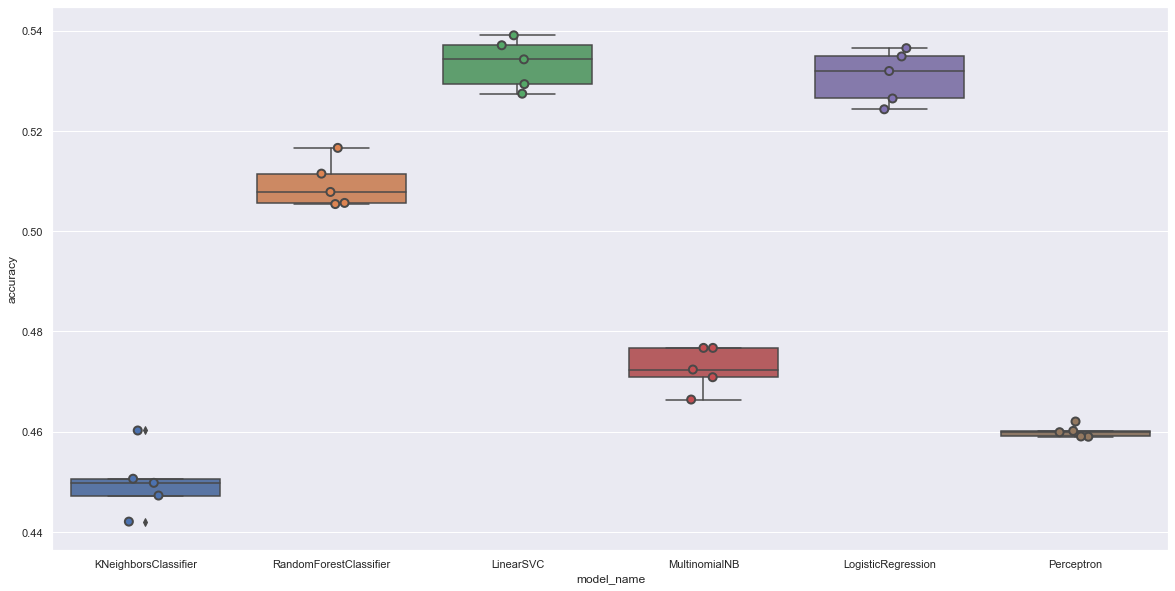

In [109]:
df_tfidf = CrossVal(X_train_binary_Tfidf,y_train)

Grid search only on Logistic Regression and LinearSVC with TfiDF vectorization as they are the best models from cross validation.

In [81]:
from sklearn.model_selection import GridSearchCV

pipe1 = Pipeline([('classifier', LogisticRegression())])
pipe2 = Pipeline([('classifier', LinearSVC())])

param_grid1 = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear','sag'],
    'classifier__multi_class' : ['multinomial','ovr']}]
param_grid2 = [{'classifier' : [LinearSVC()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__loss': ['hinge', 'squared_hinge'],
     'classifier__C' : np.arange(0.01,100,10)}]

# Grid Search
clf_lr = GridSearchCV(pipe1, param_grid = param_grid1, cv = 5, verbose=True, n_jobs=-1)
clf_lsvc = GridSearchCV(pipe2, param_grid = param_grid2, cv = 5, verbose=True, n_jobs=-1)

# Fit best model
best_lr = clf_lr.fit(X_train_binary_Tfidf,y_train)
best_lsvc = clf_lsvc.fit(X_train_binary_Tfidf,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 19.6min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 84.3min finished


In [83]:
best_lr.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                      fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                      max_iter=100, multi_class='multinomial', n_jobs=None,
                      penalty='l2', random_state=None, solver='sag', tol=0.0001,
                      verbose=0, warm_start=False))],
 'verbose': False,
 'classifier': LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='multinomial', n_jobs=None,
                    penalty='l2', random_state=None, solver='sag', tol=0.0001,
                    verbose=0, warm_start=False),
 'classifier__C': 1.623776739188721,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'clas

In [84]:
best_lsvc.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   LinearSVC(C=60.01, class_weight=None, dual=True, fit_intercept=True,
             intercept_scaling=1, loss='squared_hinge', max_iter=1000,
             multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
             verbose=0))],
 'verbose': False,
 'classifier': LinearSVC(C=60.01, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'classifier__C': 60.01,
 'classifier__class_weight': None,
 'classifier__dual': True,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__loss': 'squared_hinge',
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__tol': 0.0001,
 'classifier__verbose': 0}

In [90]:
y_train_pred1 = best_lr.predict(X_train_binary_Tfidf)
y_val_pred1 = best_lr.predict(X_test_binary_Tfidf)

print(f"Training accuracy: {accuracy_score(y_train, y_train_pred1,):.3f}")
print(f"Training F1 weighted score: {f1_score(y_train, y_train_pred1, average = 'weighted'):.3f}")

Training accuracy: 0.618
Training F1 weighted score: 0.584


In [89]:
y_train_pred2 = best_lsvc.predict(X_train_binary_Tfidf)
y_val_pred2 = best_lsvc.predict(X_test_binary_Tfidf)

print(f"Training accuracy: {accuracy_score(y_train, y_train_pred2,):.3f}")
print(f"Training F1 weighted score: {f1_score(y_train, y_train_pred2, average = 'weighted'):.3f}")

Training accuracy: 0.611
Training F1 weighted score: 0.572


In [96]:
final = pd.DataFrame()
final['PhraseId'] = test['PhraseId']
final['Sentiment'] = y_val_pred1

final.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


In [127]:
fig = plt.figure(figsize=(4,3))
final.groupby('Sentiment')['PhraseId'].count().iplot(kind='bar', yTitle='Count',
                                                linecolor='black', title='Sentiment Label Distribution - Predictions')

<Figure size 288x216 with 0 Axes>

## Conclusion ##

So far for this task the best performing model is Logistic Regression. The training accuracy of 61% does not convince me that it will be enough therefore I am moving onto BERT. BERT is known to outperform many models when it comes to NLP tasks. My work with BERT can be found in the Cadent_Sentiment_Analysis_BERT notebook.